In [1]:
## IMPORT
import sys
import os
import app_paths
import config
import imp
import f
import f_nav
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## LOCAL
imp.reload(config)
giab_vcf_dict=config.giab_vcf_dict
giab_bed_dict=config.giab_bed_dict
ref_dict=config.ref_dict
batch_dict=config.batch_dict
batch_namedict=config.batch_namedict
scriptdir='/igm/home/jbg001/git/germfilt/germline_variant_filtering/kf/script'


In [4]:
### BUILD DICTIONARIES TO RUN ALL
### ALL WE NEED TO DO IS SPECIFY BATCHNUM AND GIABNUM
## DATASETS.
## IGM 1, IGM 2.
imp.reload(f_nav)
prepydict={0:'noprepy',1:'prepy'}
rundict={1:[1,3,4],
           2:[1,2],
           3:[3,4,5],
           9:[3,4],
         
           5:[3,4],
           12:[3,4],
           7:[3,4],
           10:[6,7]
        }

prep_metadict={batchnum:{giabnum:{} for giabnum in rundict[batchnum]} for batchnum in rundict}
hapdict={}
for batchnum in rundict:
#for batchnum in [12]:
    for giabnum in rundict[batchnum]:
        for prepyflag in [0]:
            ## PREPROCESS
            sig=str(batchnum)+'_'+str(giabnum)+'_'+str(prepyflag)
            run_identifier='03062020_noon_'+prepydict[prepyflag]
            preprocessing_dict,happy_summaryfile=f_nav.init_preprocess(batchnum,giabnum,run_identifier,prepyflag)
            prep_metadict[batchnum][giabnum][prepyflag]=preprocessing_dict.copy()
            preprofile=preprocessing_dict['vcf_query_preprocessed']
            filtfile=preprofile.replace('preprocessed','filtered')
            if os.path.exists(happy_summaryfile):
                #print("Found "+sig)
                #print(os.path.getsize(preprofile),
                #      os.path.getsize(filtfile))

                hapdict[sig]=pd.read_csv(happy_summaryfile).assign(sig=sig)
                xx=2
            else:
                xx=2
                print("Missed "+sig)
                #print(happy_summaryfile)
os.system('rm /igm/home/jbg001/git/germfilt/germline_variant_filtering/kf/script/run_*preprocess*')
#prep_metadict[10][6][0]['vcf_query_preprocessed']


0

In [5]:
## BUILD TRAINING COMBO DICT
combodict={1:{1:[1],2:[3],3:[4],4:[3,4]},
           2:{1:[1],2:[2]},
           3:{1:[3],2:[4],3:[3,4],4:[5]},
           9:{1:[3],2:[4]},
           
           5:{1:[3],2:[4]},
           12:{1:[3],2:[4]},
           7:{1:[3],2:[4]},
           10:{1:[6],2:[7]}
          }
           

In [6]:
## TRAIN 
imp.reload(f_nav)
perfdict={}
featimpdict={}
train_metadict={batchnum:{comboind:{prepyflag:{} for prepyflag in [0,1]} for comboind in combodict[batchnum]} for batchnum in combodict}
train_session='granular_train_032020_afternoon'
mod_paramdict=f_nav.grab_mod_paramdict_generic_granular('X')

for batchnum in combodict:
    for combonum in combodict[batchnum]:
        for prepyflag in [0]:
            sig='_'.join([str(x) for x in [batchnum,combonum,prepyflag]])
            xxx=3
            train_paramdict=f_nav.init_train_multi(train_session,batchnum,combonum,prepyflag,mod_paramdict,prep_metadict,combodict)
            train_metadict[batchnum][combonum][prepyflag]=train_paramdict.copy()
            try:
                perffile=train_paramdict['perffile']
                perfdict[sig]=pd.read_csv(perffile).assign(sig=sig)
                featimpdict[sig]=pd.read_csv(train_paramdict['perffile'].replace('allmod_summary','feature_importances')).assign(sig=sig)
                #print("Found "+sig)
                #print("exists "+perffile)
            except:
                print("Missing "+sig)
                #print(train_paramdict['traindir'])
                xx=2
#os.system('rm /igm/home/jbg001/git/germfilt/germline_variant_filtering/kf/script/run_train*')
try:
    perfdat=pd.concat(perfdict,ignore_index=True)
    featdat=pd.concat(featimpdict,ignore_index=True)
except:
    xx=2

/igm/home/jbg001/miniconda3/envs/rnaenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/igm/home/jbg001/miniconda3/envs/rnaenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
## EXAMINE RESULTS, SET THRESH
if 1==1:
    perfdat['batch']=perfdat['sig'].apply(lambda x: int(x.split('_')[0]))
    perfdat['FP_base']=perfdat['FP']+perfdat['TN']
    perfdat['TP_base']=perfdat['TP']+perfdat['FN']
    sig='5_1_0'
# 5,7,10
viewcols=['vartype','zyg','thresh','n','TP','FP','FN','TN','sensitivity','specificity','prec_base']
#perfdat[(perfdat.batchnum==7)
#       & (perfdat.sig==sig)][viewcols]
#perfdat[(perfdat.sig==sig) & (perfdat.zyg=='hom')]


In [8]:
tabdat=pd.read_csv(train_metadict[5][1][0]['perffile'])
tabdat['modfile']='moddir/mod_'+tabdat.vartype+'_'+tabdat.zyg+'_'+tabdat.modid.apply(str)+'/mod_0.pkl'
keepcols=['vartype','zyg','modid','thresh','n','TP','FP','FN','TN']
taboutdat=pd.concat([tabdat[tabdat.thresh>=.1].sort_values(['thresh','modid']).head(15),
tabdat[tabdat.thresh>=.1].sort_values(['thresh','modid']).tail(1)],ignore_index=True)[keepcols]

In [9]:
def df_to_bitbucket_table(df):
    outstring='| '
    for j in df.columns:
        outstring+=j+' | '
    outstring+='\n'
    outstring+='| '
    for j in df.columns:
        outstring+='--- | '
    outstring +=' \n'
    for i in range(len(df)):
        outstring+='| '
        for j in df.columns:
            outstring+=str(df.iloc[i][j])+' | '
        outstring+=' \n'
    return(outstring)
outstring=df_to_bitbucket_table(taboutdat)
print(outstring)

| vartype | zyg | modid | thresh | n | TP | FP | FN | TN | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- |  
| SNP | het | 0 | 0.1 | 456631 | 454229 | 1166 | 80 | 1156 |  
| SNP | hom | 1 | 0.1 | 295853 | 295824 | 29 | 0 | 0 |  
| I1_5 | het | 2 | 0.1 | 27187 | 26409 | 453 | 9 | 316 |  
| I1_5 | hom | 3 | 0.1 | 19533 | 19102 | 353 | 7 | 71 |  
| I6_15 | het | 4 | 0.1 | 2369 | 2286 | 59 | 1 | 23 |  
| I6_15 | hom | 5 | 0.1 | 1420 | 1306 | 73 | 13 | 28 |  
| I16_PLUS | het | 6 | 0.1 | 493 | 461 | 11 | 0 | 21 |  
| I16_PLUS | hom | 7 | 0.1 | 281 | 271 | 5 | 1 | 4 |  
| D1_5 | het | 8 | 0.1 | 31999 | 30306 | 834 | 31 | 828 |  
| D1_5 | hom | 9 | 0.1 | 19461 | 19077 | 323 | 5 | 56 |  
| D6_15 | het | 10 | 0.1 | 2842 | 2661 | 114 | 10 | 57 |  
| D6_15 | hom | 11 | 0.1 | 1544 | 1445 | 77 | 7 | 15 |  
| D16_PLUS | het | 12 | 0.1 | 655 | 604 | 21 | 7 | 23 |  
| D16_PLUS | hom | 13 | 0.1 | 299 | 288 | 7 | 1 | 3 |  
| SNP | het | 0 | 0.2 | 456631 | 454174 | 948 | 135 | 1374 |  
| D16_PLU

In [112]:
## APPLY
imp.reload(f_nav)
apply_dict={
 1:{'train':'1_2_0','test':'1_3_0','thresh':{'SNP_het':.1,'D1_5_het':.1}},
 2:{'train':'2_1_0','test':'2_2_0','thresh':{'SNP_het':.1,'D1_5_het':.1}},
 3:{'train':'3_4_0','test':'3_2_0','thresh':{'SNP_het':.1,'D1_5_het':.05}},
 9:{'train':'9_1_0','test':'9_2_0','thresh':{'SNP_het':.1,'D1_5_het':.1}},

 5:{'train':'5_1_0','test':'5_2_0','thresh':{'SNP_het':.1,'D1_5_het':.1}},
 12:{'train':'12_1_0','test':'12_2_0','thresh':{'SNP_het':.1,'D1_5_het':.1}},
 7:{'train':'7_1_0','test':'7_2_0','thresh':{'SNP_het':.1,'D1_5_het':.1}},
 10:{'train':'10_1_0','test':'10_2_0','thresh':{'SNP_het':.1,'D1_5_het':.1}}  
}


intdict={}
extdict={}
chrdict={x:'21' for x in apply_dict}
testdict={}; lc=0
for i in apply_dict:
#for i in [5,12,7,10]:
    trainsig=apply_dict[i]['train']
    testsig=apply_dict[i]['test']
    threshdict=apply_dict[i]['thresh']
    batchnum=int(trainsig.split('_')[0])
    combonum_train=int(trainsig.split('_')[1])
    combonum_test=int(testsig.split('_')[1])
    giabnum_train=combodict[batchnum][combonum_train][0]
    giabnum_test=combodict[batchnum][combonum_test][0]
    train_paramdict=train_metadict[batchnum][combonum_train][0]
    mod_paramdict=f.jread(train_paramdict['mod_paramdict'])
    for modnum in mod_paramdict:
        modsig=mod_paramdict[modnum]['vartype']+'_'+mod_paramdict[modnum]['zyg']
        if modsig in threshdict:
            mod_paramdict[modnum]['thresh']=threshdict[modsig]
        else:
            mod_paramdict[modnum]['thresh']=0
    preprocessing_dict=prep_metadict[batchnum][giabnum_test][0]
    moddir_base=train_paramdict['traindir']+'/mod'
    infile=preprocessing_dict['vcf_query_preprocessed']
    locdir=preprocessing_dict['locdir']
    sumfile_ext=locdir+'/summary_external.csv'
    sumfile_int=locdir+'/summary_internal.csv'
    truthfile=locdir+'/truth_filtered_ph.vcf.gz'
    bedfile=locdir+'/giab_intersected_ph.bed'
    refnum=batch_dict[batchnum]['assembly']
    reffile=ref_dict[refnum]
    filtflag=0
    try:
        intdict[i]=pd.read_csv(sumfile_int).assign(batch=i)
    except:
        xx=1
    try:
        extdict[i]=pd.read_csv(sumfile_ext).assign(batch=i)
    except:
        xx=1
    if filtflag==1:
        scriptfile=scriptdir+'/run_bedfilt_'+str(i)+'.sh'
        chrtofilt=chrdict[i]
        filtfile=infile.replace('.vcf','_filt_'+chrtofilt+'.vcf')
        hapfile_old=locdir+'/happyout_ph.vcf.gz'
        hapfile_new=locdir+'/happyout_ph_filt_'+chrtofilt+'.vcf.gz'
        f_nav.run_bedfilt(infile,filtfile,chrtofilt,scriptfile)
        outfile=locdir+'/applied_'+train_session+'_applyid_'+str(i)+'_filt_'+chrtofilt+'.vcf'
        infile=filtfile
        scriptfile=scriptdir+'/run_hapfilt_'+str(i)+'.sh'
        truthfile_filt=truthfile.replace('.vcf.gz','_filt_'+chrtofilt+'.vcf.gz')
        f_nav.run_bedfilt(truthfile,truthfile_filt,chrtofilt,scriptfile)
        f_nav.run_bedfilt(hapfile_old,hapfile_new,chrtofilt,scriptfile)
        truthfile=truthfile_filt
    else:
        outfile=locdir+'/autofiltered_'+train_session+'_appid_'+str(i)+'.vcf'
    scriptfile=scriptdir+'/run_apply_'+str(i)+'.sh'
    print(i,os.path.exists(sumfile_int))
    #f_nav.run_apply_autofilt_papertesting(infile,outfile,moddir_base,modnumdict,mod_paramdict,thresh,scriptfile)
    #f_nav.run_apply_autofilt_papertesting_simp(infile,outfile,mod_paramdict,thresh,scriptfile)
    f_nav.run_apply_autofilt_papertesting_simp_threshindict(infile,outfile,mod_paramdict,scriptfile)
    outstring=outfile.replace('.vcf','_happed')
    scriptfile=scriptdir+'/run_happy_'+str(i)+'.sh'
    f_nav.run_justhappy(outfile,truthfile,reffile,bedfile,outstring,scriptfile)
    hapfile_extended=outstring+'.extended.csv'
    try:
        testdict[lc]=pd.read_csv(hapfile_extended).assign(
         #   thresh=thresh,
            batchnum=batchnum,giabnum_test=giabnum_test,giabnum_train=giabnum_train,appnum=i)
        #print('Found '+testsig)
    except:
        xx=2
        #print('Missing '+hapfile_extended)
    lc+=1

1 True
2 True
3 True
9 True
5 True
12 True
7 True
10 True


In [113]:
idat=pd.concat(intdict,ignore_index=True)
xdat=pd.concat(extdict,ignore_index=True)

In [114]:
#grab_tpfp(idat[(idat.batch==3) & (idat.vartype!= 'SNP') & (idat.thresh==.05)].copy())
imp.reload(config)
batchnamedict=config.batch_namedict

In [120]:
bigcutdict={}
batch=1
cutdict={
    'SNP;het':.1,
    'D1_5;het':.1}
codes_to_filt=[]
bigcutdict[batch]={'cuts':cutdict.copy(), 'codes':codes_to_filt.copy()}
batch=12
cutdict={
    'SNP;het':.4,
    'I6_15;het':.3,
    'I1_5;het':.4,
    'I16_PLUS;het':.3,   
    'D6_15;het':.3,
    'D1_5;het':.3}

batch=3
cutdict={
    'SNP;het':.4,
    'D1_5;het':.05}
codes_to_filt=['gatkRecommendIndelFilter','VQSRTrancheSNP99.9']
bigcutdict[batch]={'cuts':cutdict.copy(), 'codes':codes_to_filt.copy()}
batch=12
cutdict={
    'SNP;het':.4,
    'I6_15;het':.3,
    'I1_5;het':.4,
    'I16_PLUS;het':.3,   
    'D6_15;het':.3,
    'D1_5;het':.3}
codes_to_filt=['DRAGENHardQUAL','LowDepth']
bigcutdict[batch]={'cuts':cutdict.copy(), 'codes':codes_to_filt.copy()}
batch=10
cutdict={
    'SNP;het':.2,
    'I6_15;het':.1,
    'I1_5;het':.1,
    'I16_PLUS;het':.5,   
    'D6_15;het':.1,
    'D1_5;het':.1}
codes_to_filt=['VQLOW']
bigcutdict[batch]={'cuts':cutdict.copy(), 'codes':codes_to_filt.copy()}
batch=5
cutdict={
    'SNP;het':.4,
    'I6_15;het':.1,
    'I1_5;het':.1,
    'I16_PLUS;het':.1,   
    'D6_15;het':.1,
    'D1_5;het':.1,
    'I16_PLUS;het':.1,
    'D1_5;hom':.1
}
codes_to_filt=[]
bigcutdict[batch]={'cuts':cutdict.copy(), 'codes':codes_to_filt.copy()}


In [130]:
sumdict={}
for batch in bigcutdict:
#for batch in [3,10]:
    cutdict=bigcutdict[batch]['cuts']
    codes_to_filt=bigcutdict[batch]['codes']
    giabnum_train=combodict[batch][int(apply_dict[batch]['train'].split('_')[1])][0]
    giabnum_test=combodict[batch][int(apply_dict[batch]['test'].split('_')[1])][0]
    vcffile=prep_metadict[batch][list(prep_metadict[batch].keys())[0]][0]['vcf_query_preprocessed']
    print(batch,vcffile)
    print(vcffile)
    locdat=idat[idat.batch==batch].copy()
    zdat=locdat[locdat.thresh==0.1].groupby(['batch','vartype','zyg','y'])['n'].sum().reset_index().assign(ypred=1,thresh=0)
    locdat=pd.concat([locdat,zdat])
    locdat['vz']=locdat['vartype']+';'+locdat['zyg']
    for x in locdat.vz.unique():
        if x not in cutdict:
            cutdict[x]=0
    zdat=locdat[locdat.thresh==0.1].groupby(['batch','vartype','zyg','y'])['n'].sum().reset_index().assign(ypred=1,thresh=0)
    locdat['thresh_chosen']=locdat['vz'].apply(lambda x: cutdict[x])
    hokdat=locdat[locdat.thresh==locdat.thresh_chosen].drop(columns=['thresh_chosen','vz'])
    hokdat['vartype_full']='INDEL'
    hokdat.loc[hokdat.vartype=='SNP','vartype_full']='SNP'
    groupcols=['batch','vartype_full','y','ypred']
    intdat=hokdat.groupby(groupcols)['n'].sum().reset_index().assign(filt='int')
    exdat=xdat[xdat.batch==batch].copy()
    exdat['ypred']=1
    for code_to_filt in codes_to_filt:
        exdat.loc[exdat.FILT_string.str.contains(code_to_filt),'ypred']=0
    exdat['vartype_full']='INDEL'
    exdat.loc[exdat.vartype=='SNP','vartype_full']='SNP'
    extdat=exdat.groupby(groupcols)['n'].sum().reset_index().assign(filt='ext')
    exsumdat=extdat.groupby(['vartype_full','y','ypred'])['n'].sum().reset_index()
    intsumdat=intdat.groupby(['vartype_full','y','ypred'])['n'].sum().reset_index()
    sumdat=pd.concat([exsumdat.assign(filtstyle='ext'),intsumdat.assign(filtstyle='int')]).assign(batch=batch,
                                                  giabnum_train=giabnum_train,
                                                  giabnum_test=giabnum_test)
    sumdict[batch]=sumdat.copy()

1 /igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_1_giab_1/query_preprocessed_ph.vcf.gz
/igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_1_giab_1/query_preprocessed_ph.vcf.gz
3 /igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_3_giab_3/query_preprocessed_ph.vcf.gz
/igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_3_giab_3/query_preprocessed_ph.vcf.gz
12 /igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_12_giab_3/query_preprocessed_ph.vcf.gz
/igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_12_giab_3/query_preprocessed_ph.vcf.gz
10 /igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_10_giab_6/query_preprocessed_ph.vcf.gz
/igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_10_giab_6/query_preprocessed_ph.vcf.gz
5 /igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_5_giab_3/query_preprocessed_ph.vcf.gz
/igm/projects/FOR_JEFF/germfilt/tm/03062020_noon_noprepy_batch_5_giab_3/que

/igm/home/jbg001/miniconda3/envs/rnaenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [126]:
def grab_tpfp(df):
    tosscols=['y','ypred','n']
    groupcols=[x for x in df.columns if x not in tosscols+['TP','FP','FN','TN']]
    df['TP']=df['y']*df['ypred']*df['n']
    df['FP']=(1-df['y'])*df['ypred']*df['n']
    df['FN']=df['y']*(1-df['ypred'])*df['n']
    df['TN']=(1-df['y'])*(1-df['ypred'])*df['n']
    gf=df.groupby(groupcols).agg({x:'sum' for x in [y+z for y in ['T','F'] for z in ['P','N']]}).reset_index()
    return(gf)
humdat=pd.concat(sumdict,ignore_index=True).rename(columns={'vartype_full':'vartype'})
sumdat=grab_tpfp(humdat)
sumdat['recall']=sumdat['TP']*1.0/(sumdat.TP+sumdat.FN)
sumdat['precision']=sumdat['TP']*1.0/(sumdat.TP+sumdat.FP)
sumdat['specificity']=sumdat['TN']*1.0/(sumdat.TN+sumdat.FP)


In [127]:
imp.reload(config)
batch_namedict=config.batch_namedict
sumdat['batchname']=sumdat['batch'].apply(lambda x: batch_namedict[x])

In [129]:
sumdat_mid=sumdat.sort_values(['batch','vartype','filtstyle'],ascending=[True,False,False]).drop(columns=['recall','precision','specificity'])
sumdat_mid['filter']=sumdat_mid.apply(lambda x: 
    'AutoFilter' if x['filtstyle']=='int' 
    else ','.join(bigcutdict[x['batch']]['codes']),axis=1)
sumdat_mid['filter']=sumdat_mid.apply(lambda x: 
    x['filter'].split(',')[0] if (x['vartype']=='INDEL') and ('IndelFilter' in x['filter']) else
    (x['filter'].split(',')[1] if (x['vartype']=='SNP') and ('IndelFilter' in x['filter']) else x['filter']),axis=1)
                                  
sumdat_mid=sumdat_mid[sumdat_mid.TN > 0 ]
outcols=['vartype','batch','batchname','giabnum_train','giabnum_test','TP','FP','FN','TN','filter']
sumdat_mid[outcols]

,vartype,batch,batchname,giabnum_train,giabnum_test,TP,FP,FN,TN,filter
13,SNP,1,IGM GATK 4.1.2 WES,3,4,40939.0,63.0,8.0,266.0,AutoFilter
4,INDEL,1,IGM GATK 4.1.2 WES,3,4,3210.0,80.0,9.0,119.0,AutoFilter
14,SNP,3,Oslo joint and single exome,5,4,50456.0,49.0,9.0,85.0,AutoFilter
9,SNP,3,Oslo joint and single exome,5,4,50431.0,77.0,34.0,57.0,VQSRTrancheSNP99.9
5,INDEL,3,Oslo joint and single exome,5,4,4823.0,271.0,1.0,267.0,AutoFilter
0,INDEL,3,Oslo joint and single exome,5,4,4823.0,369.0,1.0,169.0,gatkRecommendIndelFilter
15,SNP,5,IGM NICU WGS,3,4,3028517.0,1442.0,547.0,3008.0,AutoFilter
6,INDEL,5,IGM NICU WGS,3,4,425104.0,8737.0,169.0,2550.0,AutoFilter
16,SNP,10,Complete Genomics WGS,6,7,2897506.0,8453.0,993.0,19510.0,AutoFilter
11,SNP,10,Complete Genomics WGS,6,7,2889866.0,11614.0,8633.0,16349.0,VQLOW


In [104]:
humdat=sumdat.drop(columns=['TP','FP','FN','TN'])#.rename(columns={'vartype_full':'vartype'})
valcols=['recall','precision']
pivcols=['filtstyle']
groupcols=[x for x in humdat.columns if x not in valcols+pivcols]
#pd.pivot_table(humdat,index=groupcols,values=valcols,columns=pivcols)
wumdat=humdat[(humdat.batch!= 12)]

NameError: name 'sumdat' is not defined

NameError: name 'wumdat' is not defined

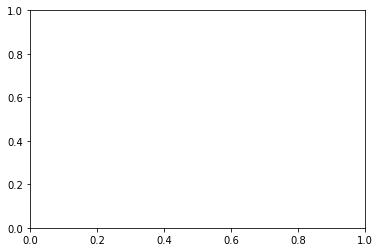

In [105]:
import math
fig,ax=plt.subplots()
cols=plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('axes', labelsize=12) 
markerdict={'ext':'^','int':'o'}
lc=0
#for batch in bigcutdict:
batch_namedict_loc={3:'Oslo WES', 10:'Complete Genomics WGS'}
external_filtdict={3:{'SNP':'VQSR','INDEL':'gatkRecommendedIndelFilter'},
                  10:{x:'VQLOW' for x in ['SNP','INDEL']}}
for batch in [3,10]:
    for vartype in ['SNP','INDEL']:
        for filtstyle in ['int','ext']:
            plotdat=wumdat[(wumdat.batch==batch)  & (wumdat.filtstyle==filtstyle) & (wumdat.vartype==vartype)]
            filtname='AutoFilter'
            if filtstyle=='ext':
                filtname=external_filtdict[batch][vartype]
            cols_custom=[cols[2],cols[3],cols[0],cols[1]]
            ax.scatter(x=plotdat.recall.apply(lambda x: -math.log10(1-x)),
                       y=plotdat.precision.apply(lambda x: -math.log10(1-x)),
                        #x=plotdat.precision,y=plotdat.recall,
                       label=batch_namedict_loc[batch]+' '+vartype+'s; '+filtname,
                       c=cols_custom[lc],marker=markerdict[filtstyle],s=200)
        lc+=1
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
xtick_labs=[1-(10 ** (-x)) for x in plt.xticks()[0]]
ytick_labs=[1-(10 ** (-x)) for x in plt.xticks()[0]]
xtick_labs=[round(x,4) for x in xtick_labs]
ytick_labs=[round(x,4) for x in ytick_labs]

plt.xticks(ticks=plt.xticks()[0],labels=xtick_labs)
plt.yticks(ticks=plt.yticks()[0],labels=ytick_labs)
plt.xlabel('Recall')
plt.ylabel('Precision')

#pfdir='/igm/home/jbg001/git/germfilt/germline_variant_filtering/plotfin'
for x in ['pdf','png']:
    plotfile=pfdir+'/precrec_forpaper.'+x
    plt.savefig(plotfile,bbox_inches='tight')

In [106]:
sumdat[(sumdat.batch==5)
    & (sumdat.vartype=='SNP')]

NameError: name 'sumdat' is not defined

In [107]:
wumdat[wumdat.recall==1]

NameError: name 'wumdat' is not defined

In [108]:
sumdict[5]

KeyError: 5

In [109]:
#xdat[['FILT_string','batch']].drop_duplicates()